# Neural Networks with Pytorch

This notebook implements the utilities from `fullyconnected_neuralnetwork.py` in an easy example.
All in all, the basic use of Pytorch is showcased: dataset loading, model definition, model training, image inferece & visualization.
The notebook is divided in 4 sections:

1. Tensors: basic usage of the tensor structure is explained
2. Main Exemplary Application: `fullyconnected_neuralnetwork.py` is employed in an easy application
3. Custom datasets: how to prepare our images to generate a dataset
4. Additional features: manually defined networks, weight & bias access

## 1. Tensors

To have an idea of the concept of tensor structures, see `tensors.py`.

## 2. Main Exemplary Application
In this section, the generic utility script for neural network training and use `fullyconnected_neuralnetwork.py` is employed in an easy application in which the Fashion-MNIST dataset is used. What is done:
- Dataset is loaded and briefly checked
- Network is created
- Network is trained
- Network is saved and loaded again
- Network is inferred


In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper_nn as hnn
import fullyconnected_neuralnetwork as fc_nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# LOAD DATASET: example, Fashion-MNIST (28x28 pixels, 1 channel, 10 classes)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('../../../DL_PyTorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.FashionMNIST('../../../DL_PyTorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


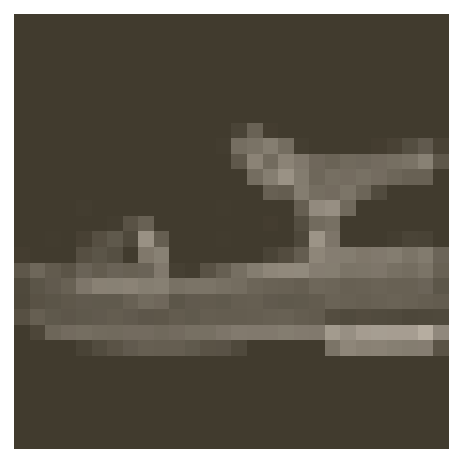

In [3]:
# CHECK DATSET
image, label = next(iter(trainloader))
print(trainset.classes)
hnn.imshow(image[0,:])

In [4]:
# Have a clear idea of the image tensor shape
# [Batch size, channels, width, height]
image.shape

torch.Size([64, 1, 28, 28])

In [5]:
# CREATE NETWORK
#input_size = 1*28*28 = 728
input_size = image.size()[1]*image.shape[2]*image.shape[3]
#output_size = 10
output_size = len(trainset.classes)
# Select desired number of hidden layers and their sizes
hidden_sizes = [512, 256, 128]
model = fc_nn.Network(input_size, output_size, hidden_sizes)
criterion = nn.NLLLoss() # Alternatives: nn.CrossEntropyLoss(), nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Alternatives: optim.SGD()

In [7]:
# TRAIN
fc_nn.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Training on cpu
Epoch: 1/2..  Training Loss: 0.465..  Test Loss: 0.442..  Test Accuracy: 0.838
Epoch: 1/2..  Training Loss: 0.484..  Test Loss: 0.433..  Test Accuracy: 0.843
Epoch: 1/2..  Training Loss: 0.488..  Test Loss: 0.460..  Test Accuracy: 0.833
Epoch: 1/2..  Training Loss: 0.524..  Test Loss: 0.438..  Test Accuracy: 0.837
Epoch: 1/2..  Training Loss: 0.488..  Test Loss: 0.432..  Test Accuracy: 0.848
Epoch: 1/2..  Training Loss: 0.544..  Test Loss: 0.429..  Test Accuracy: 0.841
Epoch: 1/2..  Training Loss: 0.511..  Test Loss: 0.440..  Test Accuracy: 0.835
Epoch: 1/2..  Training Loss: 0.473..  Test Loss: 0.440..  Test Accuracy: 0.833
Epoch: 1/2..  Training Loss: 0.528..  Test Loss: 0.434..  Test Accuracy: 0.845
Epoch: 1/2..  Training Loss: 0.474..  Test Loss: 0.428..  Test Accuracy: 0.841
Epoch: 1/2..  Training Loss: 0.490..  Test Loss: 0.419..  Test Accuracy: 0.847
Epoch: 1/2..  Training Loss: 0.501..  Test Loss: 0.430..  Test Accuracy: 0.840
Epoch: 1/2..  Training Loss: 0.500..

In [8]:
# SAVE
filename = 'my_model_checkpoint.pth'
fc_nn.save_model(filename, model, input_size, output_size, hidden_sizes)

In [9]:
# LOAD
filename = 'my_model_checkpoint.pth'
model = fc_nn.load_model(filename)
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


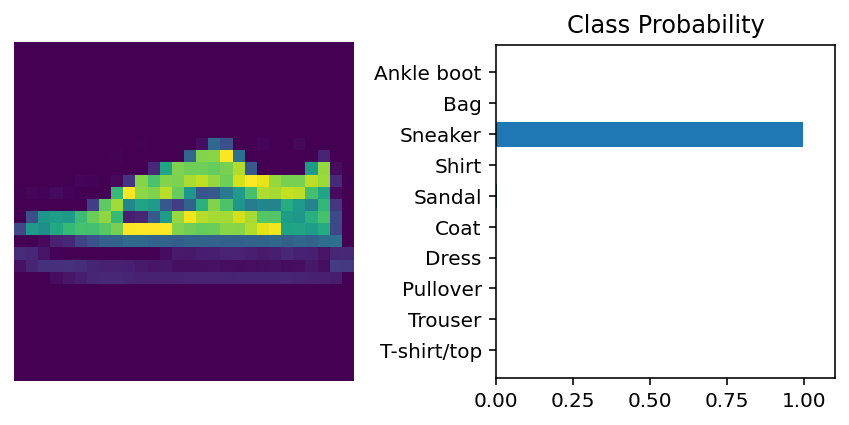

In [10]:
# INFER & VISUALIZE
model.eval()
images, labels = next(iter(testloader))
img = images[0]
#img = img.view(1, 28*28)
img = img.view(1, images.shape[2]*images.shape[3]) # Note: visualization for one channel
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
hnn.view_classify(img.view(1, images.shape[2], images.shape[3]), ps, trainset.classes)

## 3. Custom Datasets

We might want to create our own dataset from images. This section shows how this works. There are 3 elements to take into account:
- The folder which contains the images from which the **dataset** is constructed: `datasets.ImageFolder()`
- The preprocessing **transformations** we apply to the images of the dataset: `transforms.Compose()`
- The **dataset loader** which delivers the transformed and preprocessed batch from the dataset: `torch.utils.data.DataLoader()`

Additionally, note that `datasets.ImageFolder()` expects the images to be structured class folders:
```bash
    dataset/
        train/
            cats/
                cat_01.jpeg
                cat_02.jpeg
                ...
            dogs/
        test
            cats/
            dogs/
```
If not, we might have an Excel sheet or similar that annotates the classes of each images instead; in that case, we need to write a script that re-organizes the images into that folder structure. See file `organize_dataset.py` from `../pytorch_example_01/`

In [11]:
import torch
from torchvision import datasets, transforms
import helper_nn as hnn

In [16]:
# Define image folder: inside data_dir, each class should have a subfolder, eg
# path/train/dog, path/train/cat...
data_dir = '../../../DL_PyTorch/Cat_Dog_data/train'
# Compose transforms: Select transformations to squentially apply to dataset
# Resize: w (x h)
# CenterCrop: center crop with w (x h) - many pre-trained models accept 224x224 inputs
# Grayscale: convert to one channel
# We can also apply transformations for data augmentation: RandomRotation, RandomResizedCrop, RandomHorizontalFlip
# ToTensor: convert into a pytorch tensor
# Normalize: list of means & list of stds passed, so that
#   input[channel] = (input[channel] - mean[channel]) / std[channel]
#   a very typical normalization is:
#   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(125),
                                 transforms.CenterCrop(124),
                                 transforms.Grayscale(num_output_channels=3),                                
                                 transforms.ToTensor()
                               ])
# Specify the ImageFolder object
dataset = datasets.ImageFolder(data_dir, transform=transform)
# Create the DataLoader from ImageFolder: DataLoader is an iterator of the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [17]:
# Images from dataset can be extracted in two main ways:
# 1) Looping through it, get a batch on each loop 
for images, labels in dataloader:
    break
# 2) # Get one batch
images, labels = next(iter(dataloader))

In [18]:
# Have clear size of images
images.size()

torch.Size([64, 3, 124, 124])

In [19]:
labels.size()

torch.Size([64])

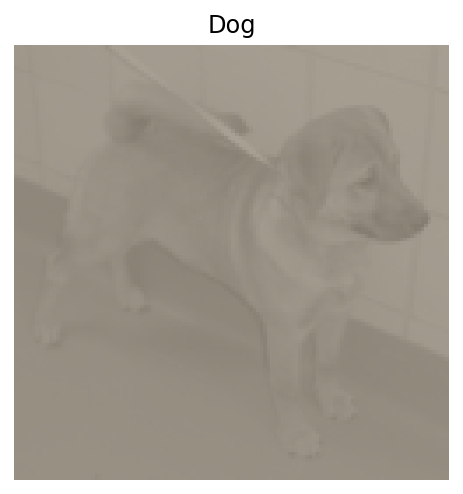

In [20]:
# Visualize first image of batch
title = 'Dog'
id = 4
if labels[id].item() == 0:
    title = 'Cat'
hnn.imshow(images[id,:], title=title)

## 4. Additional

This section covers some additional features that can be useful:
- Manual network/model definition using `nn.Sequential()`
- Model layer bias & weight value access

In [13]:
# It is also possible to create amodel with nn.Sequential()
input_size = 1*28*28
hidden_sizes = [128, 64]
output_size = 10
from collections import OrderedDict
new_model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
print(new_model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [14]:
# We can read weights and biases of any layer
new_model.fc1.weight
new_model.fc1.bias

Parameter containing:
tensor([ 0.0205, -0.0114,  0.0061, -0.0309,  0.0355,  0.0207,  0.0199,  0.0146,
         0.0036,  0.0356, -0.0143, -0.0288,  0.0217, -0.0321, -0.0242,  0.0329,
         0.0169, -0.0142,  0.0324,  0.0121, -0.0157, -0.0150, -0.0257, -0.0163,
        -0.0334,  0.0282,  0.0353, -0.0031, -0.0249, -0.0327,  0.0098,  0.0316,
         0.0302,  0.0246,  0.0344,  0.0264, -0.0013, -0.0263,  0.0188, -0.0353,
        -0.0133,  0.0201,  0.0230,  0.0058,  0.0102, -0.0010, -0.0208,  0.0150,
        -0.0294,  0.0102,  0.0347,  0.0197,  0.0021, -0.0204,  0.0267, -0.0170,
         0.0158,  0.0112, -0.0077, -0.0261, -0.0227,  0.0165, -0.0036, -0.0347,
        -0.0266,  0.0271, -0.0242, -0.0202, -0.0300,  0.0069,  0.0222, -0.0137,
         0.0104, -0.0128, -0.0047, -0.0063, -0.0109, -0.0216,  0.0137, -0.0159,
         0.0094, -0.0048,  0.0356, -0.0343, -0.0282, -0.0099,  0.0017,  0.0288,
        -0.0269,  0.0253, -0.0292, -0.0120, -0.0036,  0.0018, -0.0150,  0.0057,
         0.0199, -

In [15]:
# We could set biases to all zeros
new_model.fc1.bias.data.fill_(0)
# We could sample from random normal (mean = 0) with standard dev = 0.01
new_model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0079, -0.0078,  0.0028,  ...,  0.0194,  0.0254, -0.0086],
        [-0.0120, -0.0139, -0.0115,  ...,  0.0136, -0.0214, -0.0136],
        [-0.0018,  0.0111, -0.0122,  ..., -0.0109,  0.0240,  0.0054],
        ...,
        [ 0.0054,  0.0035,  0.0059,  ..., -0.0139,  0.0061, -0.0063],
        [ 0.0010, -0.0092,  0.0070,  ...,  0.0046, -0.0026, -0.0008],
        [ 0.0125,  0.0158, -0.0054,  ..., -0.0031, -0.0029, -0.0080]])